## Supervised learning 

In this particular problem, it's very very important to have *ZERO False Negatives*. The metrics are:

Symbol  | Description              | Formula              | Comments
------- | ------------------------ | -------------------- |
$$TP$$  | True positives           |                      |
$$FP$$  | False positives          |                      |
$$TN$$  | True negatives           |                      |
$$FN$$  | False negatives          | Values classified negative, actually positive |
$$FPR$$ | False Positives Rate     | $${FP}/{(TN+FP)}$$ |
$$FNR$$ | **False Negatives Rate** | $${FN}/{(TP+FN)}$$ |Should be zero / near to zero
pre     | Precision                | $${FN}/{(TP+FN)}$$ |
sen     | **Sensitivity**          | $${TP}/{(TP+FN)}$$ | Its equal to $$1-FNR$$
spec    | Specificity              | $${TN}/{(TN+FP)}$$ |


In [1]:
import pandas as pd
from pandas import HDFStore
import matplotlib.pyplot as plt
from utils_preproc import *
from utils_ml import *

C:\Users\Susana\Anaconda2\envs\py3k\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
base_dir = 'D://VBox/data/itm_ecuador/visualization/'
plots_dir = {2013 : base_dir+'Plots2013', 2014 : base_dir+'Plots2014'}

# Load events manual classification 
ev_class = pd.read_csv('D://phd/data/labels.csv')

# Load descriptors 
desc_file = 'D://phd/data/desc_layer_1.h5'
x, y = load_descriptors_layer_1(desc_file, ev_class=ev_class)

# The data preparation pipeline consists of:
# split_train_test -> class_balance -> scale -> pca_transform
x_train, x_test, y_train, y_test = pipeline(x, y)

train_target = y_train.valid_event
test_target = y_test.valid_event


Dataset size (8471, 55)
Train size:	 (5929, 55)
Test size:	 (2542, 55)


C:\Users\Susana\Anaconda2\envs\py3k\lib\site-packages\pandas\core\frame.py:2352: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[0.25101278 0.49908598 0.57744519 0.65474956 0.69800803 0.73783188
 0.77231261 0.79483957 0.81608254 0.8359325  0.85333528 0.86834374
 0.88243905 0.89572916 0.90825732 0.92003749 0.93070461 0.9404079
 0.94946862 0.95602488 0.96153052 0.96684633 0.97145675 0.97593064
 0.97967875 0.98294248 0.98576353 0.98797839 0.99000681 0.99140655
 0.99265571 0.99358005 0.99443989 0.99507671 0.99565182 0.99614419
 0.99654984 0.99693463 0.99729529 0.99762573 0.99793604 0.99822997
 0.99849161 0.99873129 0.99893784 0.99911844 0.99927363 0.99941523
 0.99954916 0.99966844 0.99976183 0.99984647 0.99991684 0.99997694
 1.        ]
Final datasets size:
Train size:	 (10568, 10)
Test size:	 (2542, 10)


In [4]:
def eval_model(x, y, model):

    y_pred = model.predict(x)
    print("Number of mislabeled points out of a total %d points : %d" % (x.shape[0],(y != y_pred).sum()))
    
    a = np.array(y,dtype="b")
    b = np.array(y_pred,dtype="b")
    
    cm = confusion_matrix(a,b,labels=[0,1])
    plot_confusion_matrix(cm, ["False","True"])
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    print(confusion_matrix(y, y_pred))

    fpr = 100*fp/(tn+fp)
    fnr = 100*fn/(tp+fn)
    print('FPR: %.2f' % round(fpr, 1), 
          '\t FNR: %.2f' % round(fnr, 1))
    return


******* train *******
Number of mislabeled points out of a total 10568 points : 988


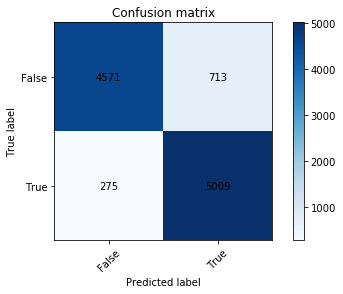

[[4571  713]
 [ 275 5009]]
FPR: 13.50 	 FNR: 5.20

******* test *******
Number of mislabeled points out of a total 2542 points : 338


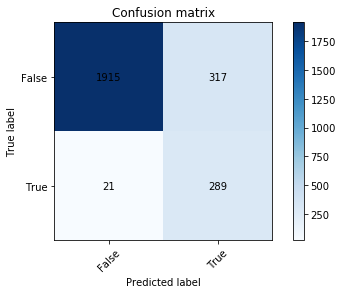

[[1915  317]
 [  21  289]]
FPR: 14.20 	 FNR: 6.80


In [5]:
### Naive bayes classifier
gnb = GaussianNB()
model = gnb.fit(x_train, train_target)
print("\n******* train *******")
eval_model(x_train, train_target, model)
print("\n******* test *******")
eval_model(x_test, test_target, model)



******* train *******
Number of mislabeled points out of a total 10568 points : 626


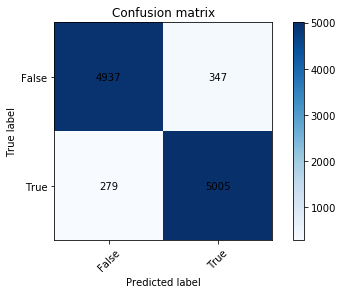

[[4937  347]
 [ 279 5005]]
FPR: 6.60 	 FNR: 5.30

******* test *******
Number of mislabeled points out of a total 2542 points : 138


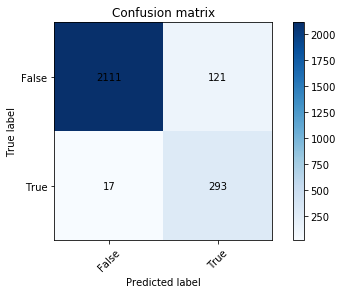

[[2111  121]
 [  17  293]]
FPR: 5.40 	 FNR: 5.50


In [6]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression
lrc = LogisticRegression()
model = lrc.fit(x_train, train_target)
print("\n******* train *******")
eval_model(x_train, train_target, model)
print("\n******* test *******")
eval_model(x_test, test_target, model)


******* train *******
Number of mislabeled points out of a total 10568 points : 1


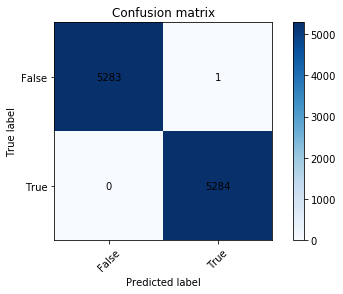

[[5283    1]
 [   0 5284]]
FPR: 0.00 	 FNR: 0.00

******* test *******
Number of mislabeled points out of a total 2542 points : 110


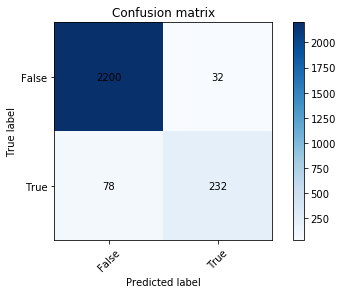

[[2200   32]
 [  78  232]]
FPR: 1.40 	 FNR: 25.20


In [7]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10)#,random_state=1234)
model = rfc.fit(x_train, train_target)
print("\n******* train *******")
eval_model(x_train, train_target, model)
print("\n******* test *******")
eval_model(x_test, test_target, model)

## Models performance summary


| Model | Train FNR | Test FNR | Train FPR | Test FPR | Train Acc | Test Acc |  
|:-:|:-:    |
| Naive bayes        | 5.2 | 6.8 | 13.5 | 14.2 | 0.91 | 0.87 |
| LogisticRegression | 5.3 | 5.3 | 6.6 | 5.4   | 0.94 | 0.95 |
| RandomForestClassifier | 0 | 0 | 1.4 | 25.2  | 0.99 | 0.96 |